In [25]:
# ! pip install yfinance arch py_vollib

In [26]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import norm
from arch import arch_model
import warnings
import seaborn as sns
import math
import random
import matplotlib.pyplot as plt
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import delta
import scipy.stats as sps
import matplotlib.colors as mcolors
import logging

In [27]:
# Choosing the 3 stocks from the S&P 500 index
interval     = '1wk'   # 1d or 1wk
year_length  = 252 if interval == '1d' else 52
tickers      = ['aapl', 't', 'blk' , 'msft']
early_price  = yf.download(tickers, start='2021-01-01', end='2023-09-30', interval=interval)['Adj Close']
late_price   = yf.download(tickers, start='2021-05-01', end='2022-12-31', interval=interval)['Adj Close']
early_return = np.log(early_price.pct_change().dropna())
late_return  = np.log(late_price.pct_change().dropna())

/Users/syrkis/.pyenv/versions/3.11.7/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[                       0%%                      ]/Users/syrkis/.pyenv/versions/3.11.7/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/Users/syrkis/.pyenv/versions/3.11.7/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[**********************50%%                      ]  2 of 4 completed/Us

In [28]:
''' fig, ax = plt.subplots(figsize=(20, 5), layout='constrained')
ax.plot(log_returns['AAPL'], label='AAPL')
#ax.plot(returns['BLK'], label='BLK')
#ax.plot(returns['MSFT'], label='MSFT')
#ax.plot(returns['T'], label='T')
ax.set_xlabel('Time')
ax.set_ylabel('Returns')
ax.set_title("")
ax.legend() '''

' fig, ax = plt.subplots(figsize=(20, 5), layout=\'constrained\')\nax.plot(log_returns[\'AAPL\'], label=\'AAPL\')\n#ax.plot(returns[\'BLK\'], label=\'BLK\')\n#ax.plot(returns[\'MSFT\'], label=\'MSFT\')\n#ax.plot(returns[\'T\'], label=\'T\')\nax.set_xlabel(\'Time\')\nax.set_ylabel(\'Returns\')\nax.set_title("")\nax.legend() '

In [29]:
''' fig, ax = plt.subplots(figsize=(20, 5), layout='constrained')
ax.plot(prices['AAPL'], label='AAPL')
#ax.plot(prices['BLK'], label='BLK')
#ax.plot(prices['MSFT'], label='MSFT')
#ax.plot(prices['T'], label='T')
ax.set_xlabel('Time')
ax.set_ylabel('Prices')
ax.set_title("")
ax.legend() '''

' fig, ax = plt.subplots(figsize=(20, 5), layout=\'constrained\')\nax.plot(prices[\'AAPL\'], label=\'AAPL\')\n#ax.plot(prices[\'BLK\'], label=\'BLK\')\n#ax.plot(prices[\'MSFT\'], label=\'MSFT\')\n#ax.plot(prices[\'T\'], label=\'T\')\nax.set_xlabel(\'Time\')\nax.set_ylabel(\'Prices\')\nax.set_title("")\nax.legend() '

In [30]:
def BS(r, S, K, T, sigma, type="call"):
    "Finction calculating the Black-Scholes price of a European call or put option."

    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if type == "call":
        BS_price = S * sps.norm.cdf(d1, 0, 1) - K * np.exp(-r * T) * sps.norm.cdf(d2, 0, 1)
    elif type == "put":
        BS_price = K * np.exp(-r * T) * sps.norm.cdf(-d2, 0, 1) - S * sps.norm.cdf(-d1, 0, 1)

    return BS_price

# print("Black-Scholes call option price: ", BS(r,S,K,T,sigma,"call"))
# print("Black-Scholes put option price:  ", BS(r,S,K,T,sigma,"put"))

In [31]:
def delta_(r, S, K, T, sigma, type="call"):
    "Finction calculating the delta of a European call or put option."

    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma * np.sqrt(T))

    if type == "call":
        delta_tmp = sps.norm.cdf(d1, 0, 1)
    elif type == "put":
        delta_tmp = - sps.norm.cdf(-d1, 0, 1)

    return delta_tmp

# print("Delta call option: ", delta_(r,S,K,T,sigma,"call"))
# print("Delta put option: ", delta_(r,S,K,T,sigma,"put"))

In [32]:
# Defiling variables for the BS model
tick    = 'BLK'
r       = 0.05
S       = early_price[tick].iloc[-1]
K       = S + 5
T       = 0.25 # 1/4 of a year
sigma   = early_return[tick].std()
n_stcks = 100_000

In [33]:
stock  = np.array(late_price[tick])
deltas = np.array([delta_(r, stock[i], K, (len(stock) - i) / year_length, sigma, 'call') for i in range(len(stock))])
num_tb = np.pad(deltas[1:] - deltas[:-1] * n_stcks, 1)[:-1]
costs  = num_tb * stock[:1]

In [34]:
cont_comp = lambda x : x * (np.exp(r / year_length) - 1)
total_cost, interest = [costs[0]], [cont_comp(costs[0])]
for i in range(1, len(stock)):
    total_cost += [total_cost[i-1] + interest[i - 1] + costs[i]]
    interest   += [cont_comp(total_cost[i])]

In [35]:
cum_boring                   = total_cost[-1]
selling_the_stock_for_k      = n_stcks * K
total_cost_of_writing_option = cum_boring - selling_the_stock_for_k
discount                     = total_cost_of_writing_option * np.exp(- r / year_length * len(stock))

In [37]:
bull_shit = BS(r, S, K, T, sigma) * n_stcks
# error = (discount - bull_shit) / bull_shit
# error * 100
BS(r, S, K, T, sigma)

146.54405698606888

Text(0.5, 1.0, 'Delta')

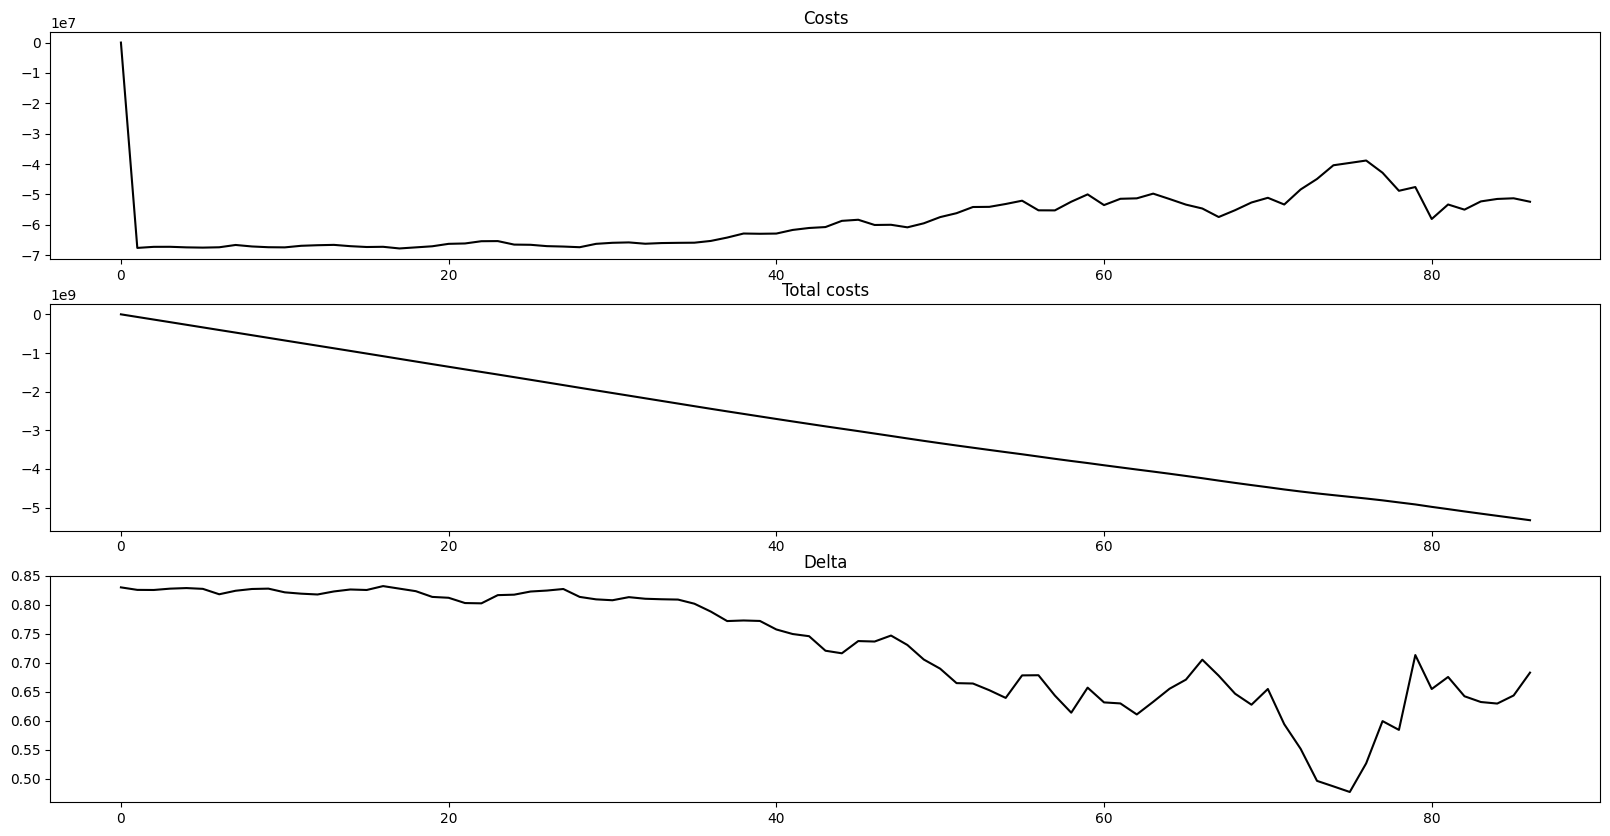

In [49]:

# nice matplot lib theme
fig, axes = plt.subplots(3, 1, figsize=(20, 10), dpi=100)
axes[0].plot(costs, c='k')
axes[0].set_title('Costs')
axes[1].plot(total_cost, c='k')
axes[1].set_title('Total costs')
axes[2].plot(deltas, c='k')
axes[2].set_title('Delta')
plt.savefig('delta_hedge.png', dpi=200)
